In [1]:
import torch as th
import torch.nn as nn
import torch.optim as optim

from src.model import VAE
from src.trainer import Trainer

device = th.device('cuda' if th.cuda.is_available() else 'cpu')

print('device is', device)

device is cuda


In [2]:
VAE_CFG = {
    # (in_ch, out_ch, kernel, stride, padding)
    'en_cnn_arch' : [
        # shape(*, 3, 128, 128)
        (3, 32, 4, 2, 1),   # shape(*, 32, 64, 64)
        (32, 64, 4, 2, 1),  # shape(*, 64, 32, 32)
        (64, 128, 4, 2, 1), # shape(*, 128, 16, 16)
        (128, 256, 4, 2, 1),# shape(*, 256, 8, 8)
        (256, 256, 4, 2, 1),# shape(*, 256, 4, 4)
    ],
    'en_fc_arch' : [4096, 256, 64],
    'de_fc_arch' : [64, 256, 4096],
    'de_cnn_in_shape' : (256, 4, 4),
    # (in_ch, out_ch, kernel, stride, padding, output_padding)
    'de_cnn_arch' : [
        # shape(*, 256, 4, 4)
        (256, 256, 4, 2, 1, 0), # shape(*, 256, 8, 8)
        (256, 128, 4, 2, 1, 0), # shape(*, 128, 16, 16)
        (128, 64, 4, 2, 1, 0),  # shape(*, 64, 32, 32)
        (64, 32, 4, 2, 1, 0),   # shape(*, 32, 64, 64)
        (32, 3, 4, 2, 1, 0),    # shape(*, 3, 128, 128)
    ],
    'activ_fn' : nn.ReLU
}

BATCH_SIZE = 512
LR = 0.003
N_WORKERS = 8

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose

dataset = datasets.CelebA(
    root='torch_dataset',
    split='train',
    download=False,
    transform=Compose([
        ToTensor(),
        Resize(size=(128,128))
    ])
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=N_WORKERS)

vae = VAE(**VAE_CFG)
# vae.load('./checkpoint/model.pt')
vae.to(device)
optimizer = optim.Adam(params=vae.parameters(),lr=LR)

trainer = Trainer(vae, optimizer, dataloader, device)

In [4]:
trainer.train(
    n_epoch=100,
    log_freq=50,
    directory='./celeba_models'
)

| epoch 0/100 | batch 49/317 | recon loss 14844.925 | regul loss 619.428747 |
| epoch 0/100 | batch 99/317 | recon loss 4492.788 | regul loss 1.105262 |
| epoch 0/100 | batch 149/317 | recon loss 3402.473 | regul loss 32.134741 |
| epoch 0/100 | batch 199/317 | recon loss 2488.396 | regul loss 72.203917 |
| epoch 0/100 | batch 249/317 | recon loss 2049.601 | regul loss 86.987040 |
| epoch 0/100 | batch 299/317 | recon loss 1910.718 | regul loss 84.197030 |
| epoch 1/100 | batch 49/317 | recon loss 1844.444 | regul loss 77.338656 |
| epoch 1/100 | batch 99/317 | recon loss 1749.504 | regul loss 85.331276 |
| epoch 1/100 | batch 149/317 | recon loss 1579.221 | regul loss 93.995858 |
| epoch 1/100 | batch 199/317 | recon loss 1543.665 | regul loss 87.834031 |
| epoch 1/100 | batch 249/317 | recon loss 1506.057 | regul loss 83.445139 |
| epoch 1/100 | batch 299/317 | recon loss 1490.622 | regul loss 79.069008 |
| epoch 2/100 | batch 49/317 | recon loss 1469.182 | regul loss 76.403308 |
| e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17905529..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00065001356..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


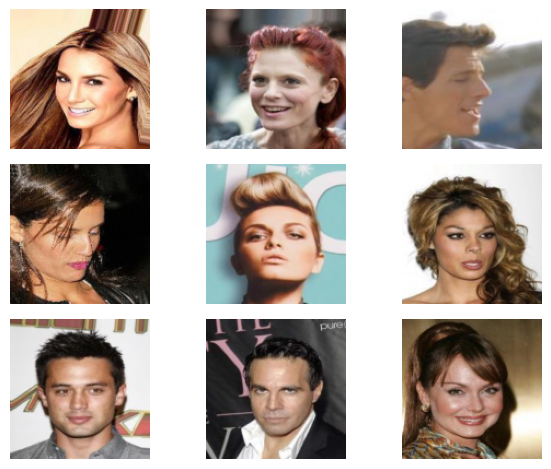

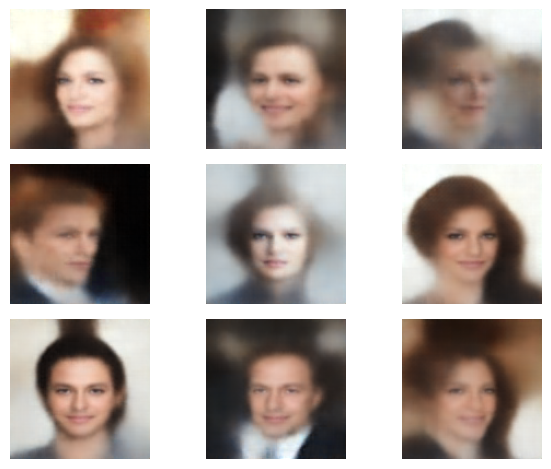

In [15]:
from src.utils import display_image

x = th.stack([dataset[k][0] for k in range(9)], dim=0).to(device)

with th.no_grad() :
    z,_ = vae.encode(x)
    y = vae.decode(z).clip(0.0,1.0)

display_image(img=x.to('cpu'), grid_shape=(3,3))
display_image(img=y.to('cpu'), grid_shape=(3,3))

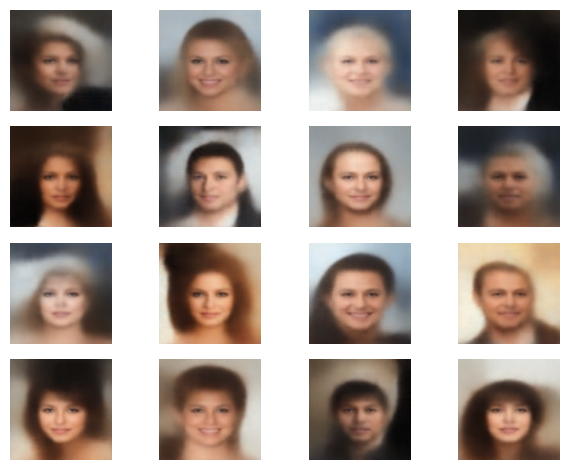

In [20]:
from src.utils import display_image

latent_space = VAE_CFG['en_fc_arch'][-1]
z = th.randn(16, latent_space, device=device)

with th.no_grad():
    y = vae.decode(z).clip(0.0,1.0)

display_image(img=y.to('cpu'), grid_shape=(4,4))